In [30]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
train_data_path = "C:\\Users\\tkdwl\\Aiffel\\node10\\data\\train.csv"
sub_data_path = "C:\\Users\\tkdwl\\Aiffel\\node10\\data\\test.csv"

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [32]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [33]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

features = ["waterfront","view","condition","grade"]
X = data[features]
y = data["price"]

# 1) 스케일링
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 2) 회귀모델로 가중치 구하기
model = LinearRegression()
model.fit(X_scaled, y)
weights = model.coef_

# 3) 가중합 계산
weighted_score = (X_scaled * weights).sum(axis=1)
data["weighted_score"] = weighted_score

print("가중치:", dict(zip(features, weights)))
print(data[["price","weighted_score"]])

가중치: {'waterfront': np.float64(602514.3309937121), 'view': np.float64(364180.37954295264), 'condition': np.float64(274882.61262363166), 'grade': np.float64(2365551.2572256057)}
           price  weighted_score
0       221900.0    1.320217e+06
1       180000.0    1.123088e+06
2       510000.0    1.517346e+06
3       257500.0    1.320217e+06
4       291850.0    1.320217e+06
...          ...             ...
15030   610685.0    1.714475e+06
15031  1007500.0    1.714475e+06
15032   360000.0    1.517346e+06
15033   400000.0    1.517346e+06
15034   325000.0    1.320217e+06

[15035 rows x 2 columns]


In [34]:
sub_scaled = scaler.transform(sub[features])
weighted_score = (sub_scaled * weights).sum(axis=1)
sub["weighted_score"] = weighted_score
sub.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,weighted_score
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,1.320217e+06
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,1.457658e+06
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,...,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930,2.108734e+06
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,...,1050,730,1960,0,98146,47.5123,-122.337,1780,8113,1.320217e+06
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,...,1890,0,2003,0,98038,47.3684,-122.031,2390,7570,1.320217e+06


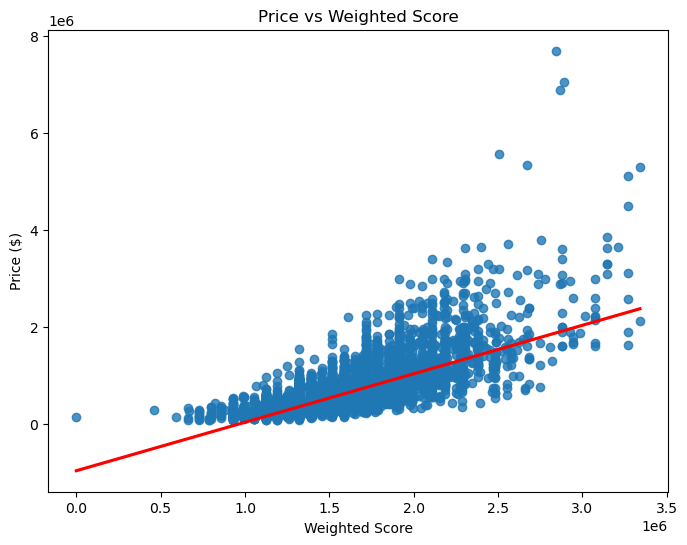

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# 산점도 + 회귀선
plt.figure(figsize=(8,6))
sns.regplot(x=data["weighted_score"], y=data["price"], ci=None, line_kws={"color":"red"})

plt.title("Price vs Weighted Score")
plt.xlabel("Weighted Score")
plt.ylabel("Price ($)")
plt.show()

In [36]:
X = data[["weighted_score"]]
y = data["price"]

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

data["residuals"] = y - y_pred
# 절대 잔차가 너무 큰 값 제거 (예: 평균 ± 2*표준편차)
std_resid = data["residuals"].std()
df_filtered = data[data["residuals"].abs() < 5*std_resid]
df_filtered.shape

(14963, 23)

In [37]:
y = df_filtered['price']

del df_filtered['price']

In [38]:
train_len = len(df_filtered)
data = pd.concat((df_filtered, sub), axis=0)

In [39]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,weighted_score,residuals
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,...,0,1955,0,98178,47.5112,-122.257,1340,5650,1.320217e+06,-134973.533526
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,...,0,1933,0,98028,47.7379,-122.233,2720,8062,1.123088e+06,20255.737910
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,...,0,1987,0,98074,47.6168,-122.045,1800,7503,1.517346e+06,-44002.804961
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,...,0,1995,0,98003,47.3097,-122.327,2238,6819,1.320217e+06,-99373.533526
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,...,0,1963,0,98198,47.4095,-122.315,1650,9711,1.320217e+06,-65023.533526


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<Axes: >

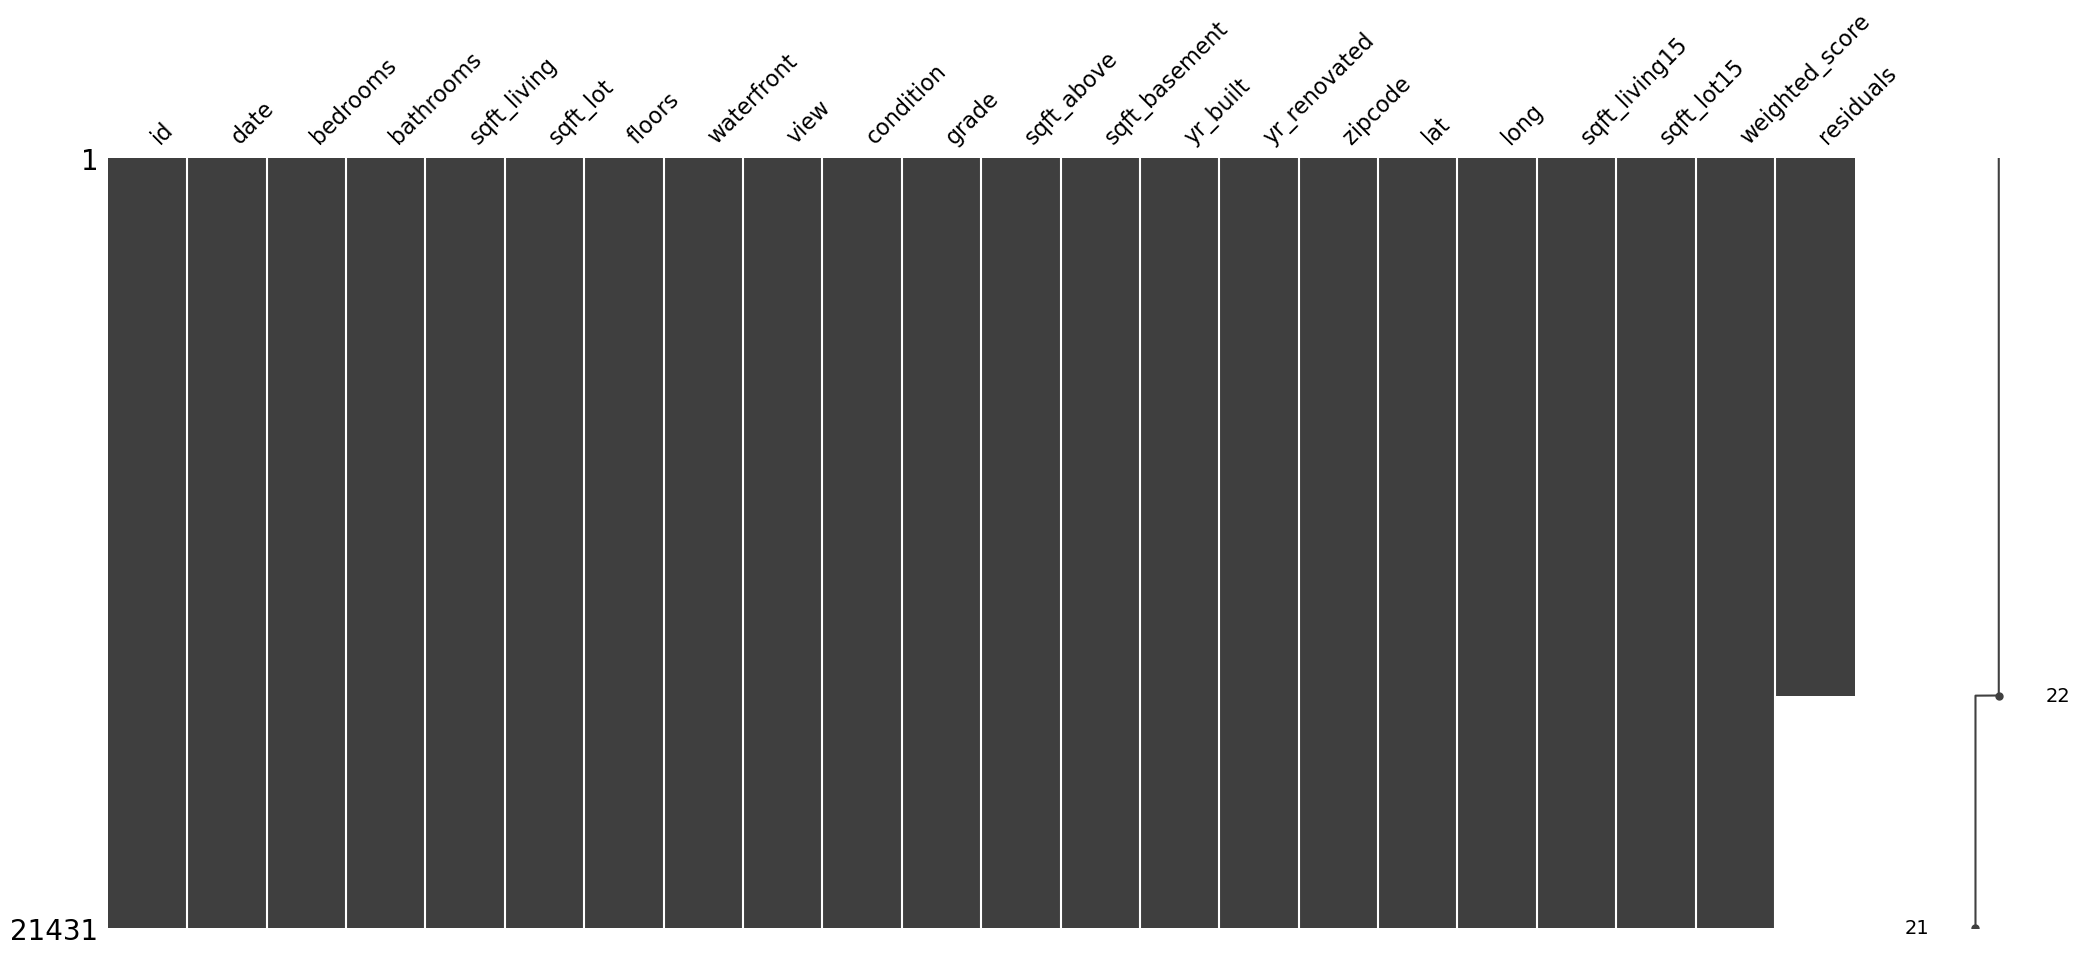

In [40]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [41]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0
weighted_score : 0
residuals : 6468


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [42]:
sub_id = data['id'][train_len:]
del data['id']
del data['condition']
del data['grade']
del data['view']
del data['waterfront']
del data['residuals']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(int)

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

IndexError: index 16 is out of bounds for axis 0 with size 16

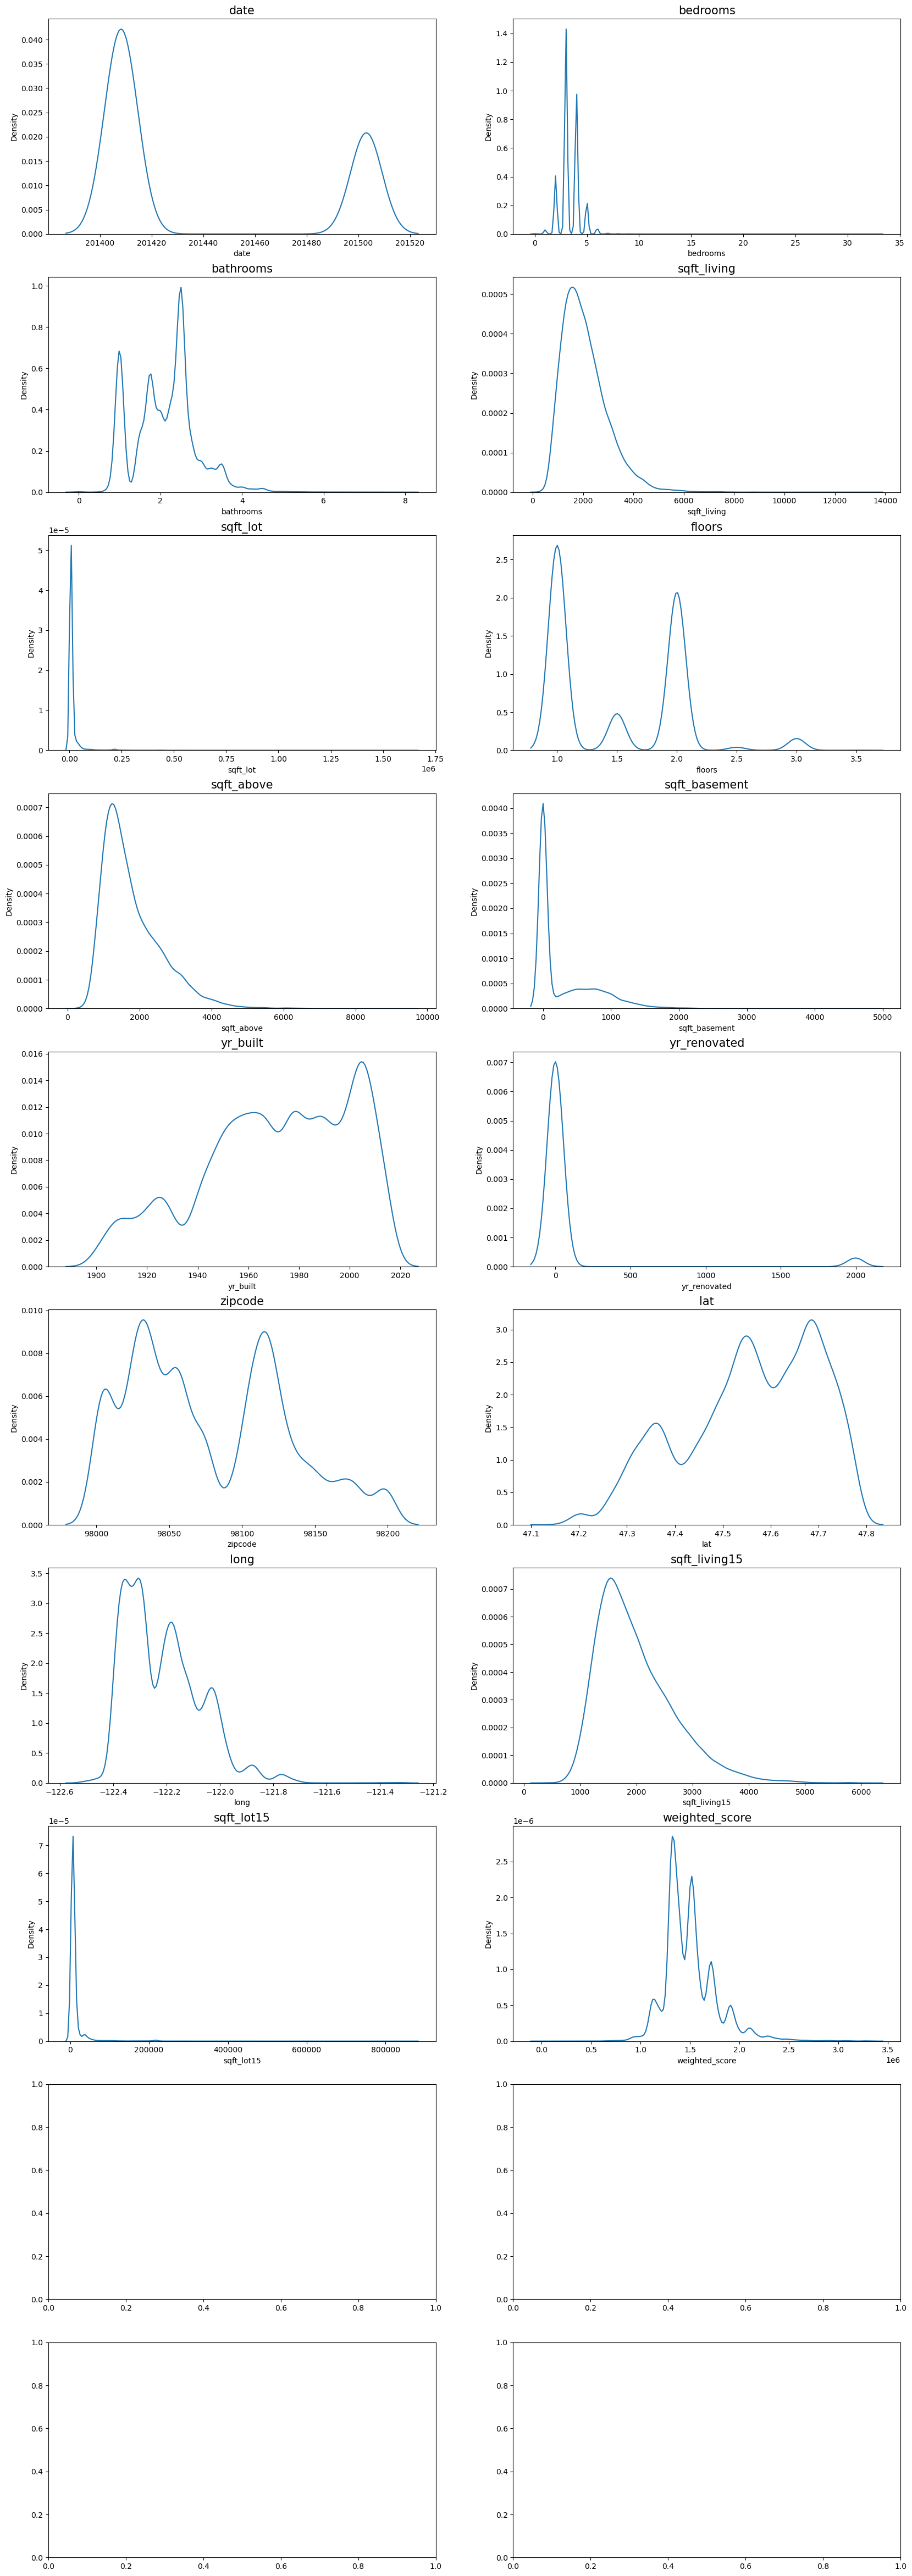

In [43]:
fig, ax = plt.subplots(10, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [44]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

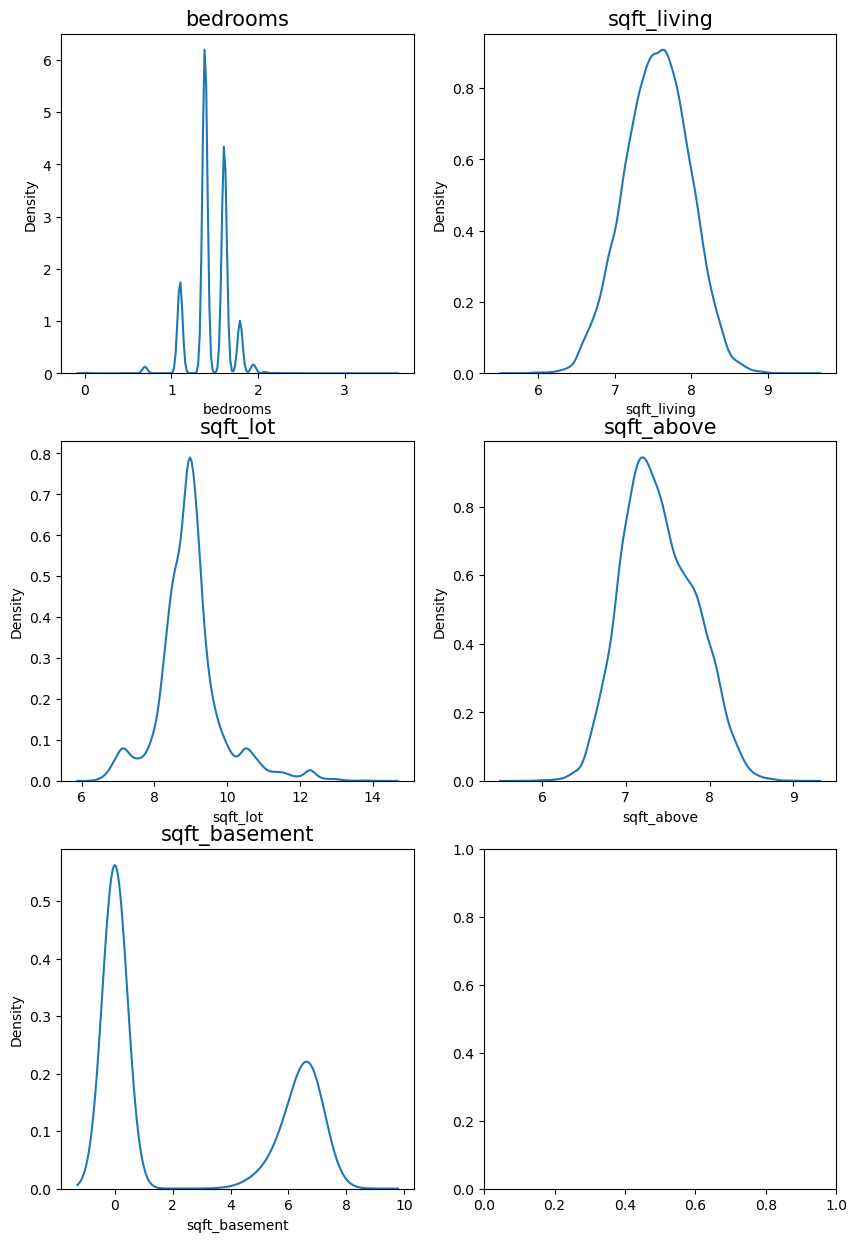

In [45]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [46]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

In [47]:
x.head()
x.shape

(14963, 16)

## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [48]:
gboost = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=2019
)

xgboost = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    random_state=2019
)

lightgbm = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=2019
)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [49]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019, shuffle=True).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))

In [50]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8861
Model XGBoost CV score : 0.9005
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2375
[LightGBM] [Info] Number of data points in the train set: 11970, number of used features: 16
[LightGBM] [Info] Start training from score 529217.826984
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2380
[LightGBM] [Info] Number of data points in the train set: 11970, number of used features: 16
[LightGBM] [Info] Start training from score 530687.424311
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2385
[LightGBM] [Info] Number of data poin

### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [51]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [52]:
y_pred = AveragingBlending(models, x, y, sub)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2421
[LightGBM] [Info] Number of data points in the train set: 14963, number of used features: 16
[LightGBM] [Info] Start training from score 528045.354541


In [53]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [54]:
sub.to_csv('submission.csv', index=False)